# Datasets

Connect to Kaggle, get and upload api token. [Follow me to get Kaggle API Tokem](https://www.kaggle.com/general/74235)

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lnguyngiabo","key":"22b1a203b341208dd8208b0fa19646f5"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Download datasets

In [4]:
!kaggle datasets download -d sachinpatel21/az-handwritten-alphabets-in-csv-format

100% 185M/185M [00:01<00:00, 183MB/s]



In [5]:
!kaggle competitions download -c digit-recognizer

  0% 0.00/9.16M [00:00<?, ?B/s]
100% 9.16M/9.16M [00:00<00:00, 151MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 74.2MB/s]
  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 202MB/s]


Unzip

In [6]:
!unzip train.csv.zip
!unzip az-handwritten-alphabets-in-csv-format.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  az-handwritten-alphabets-in-csv-format.zip
  inflating: A_Z Handwritten Data.csv  
  inflating: A_Z Handwritten Data/A_Z Handwritten Data.csv  


Create datasets folder

In [7]:
%mkdir dataset

Import Library

In [1]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras.preprocessing.image import load_img
import tensorflow as tf
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt

Create number dataset


In [9]:
for i in range(10):
    os.mkdir('dataset/' + str(i))

with open("train.csv") as f:
    content = f.readlines()

lines = np.array(content)
num_of_instances = lines.size

for i in range(1,num_of_instances):
    try:
        img = lines[i].split(",")
        pixels = img[1:]

        pixels = np.array(pixels, 'float32')
        image = pixels.reshape(28, 28)

        path_file_name = 'dataset/' + str(img[0]) +"/" + str(i) + ".jpg"
        cv2.imwrite(path_file_name, image)

    except Exception as ex:
    	print(ex)

Create character dataset

In [10]:
for j in range(26):
    os.mkdir('dataset/' + chr(j+65))

with open("A_Z Handwritten Data.csv") as f:
    content = f.readlines()

lines = np.array(content)
num_of_instances = lines.size

for i in range(0, num_of_instances):
    try:
        img = lines[i].split(",")
        pixels = img[:-1]
        pixels = np.array(pixels, 'float32')
        image = pixels.reshape(28, 28)

        path_file_name = 'dataset/' + chr(int(img[0])+65) +"//" + str(i) + ".jpg"
        cv2.imwrite(path_file_name, image)

    except Exception as ex:
        print(ex)

In [2]:
dataset_paths = glob.glob("dataset/**/*.jpg")

Plot some data

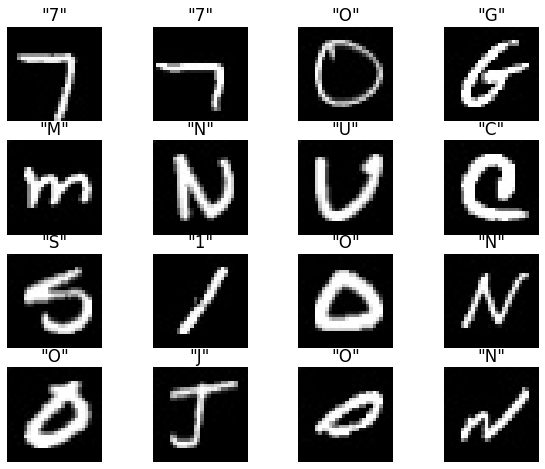

In [12]:
cols=4
rows=4
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

Plot data distribution 

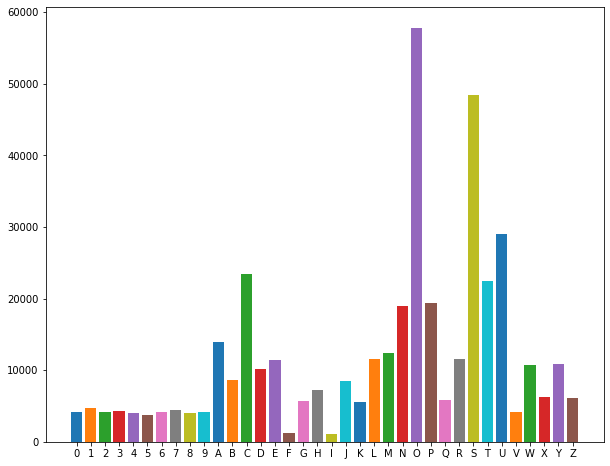

In [3]:
character_size = []
directory = 'dataset/'
list_folder = os.listdir(directory)
fig = plt.figure(figsize=(10,8))
for folder in list_folder:
  count = 0
  for file in os.listdir(directory + folder):
    count +=1
  character_size.append([folder, count])
character_size.sort()
for i in  character_size:
  plt.bar(i[0], i[1])
plt.show()


Data balancce

In [4]:
character_size.sort(key = lambda x: x[1]) 
minimum_data = character_size[0][1]

Create dataset

In [5]:
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  if(labels.count(label) == minimum_data):
    continue
  image=tf.keras.preprocessing.image.load_img(image_path,target_size=(80,80))
  image=tf.keras.preprocessing.image.img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

Save labels

In [6]:
lb = preprocessing.LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = tf.keras.utils.to_categorical(labels)

# save label file so we can use in another script
np.save('license_character_classes.npy', lb.classes_)

Split train data and test data

In [7]:
# split 10% of data as validation set
(trainX, testX, trainY, testY) = model_selection.train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

Data augmentation

In [8]:
# generate data augumentation method
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

# Model

Create Model

In [9]:
def create_model(lr=1e-4,decay=1e-4/25, training=False,output_shape=y.shape[1]):
    baseModel = tf.keras.applications.MobileNetV2(weights="imagenet", 
                            include_top=False,
                            input_tensor=tf.keras.Input(shape=(80, 80, 3)))

    headModel = baseModel.output
    headModel = tf.keras.layers.AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = tf.keras.layers.Flatten(name="flatten")(headModel)
    headModel = tf.keras.layers.Dense(128, activation="relu")(headModel)
    headModel = tf.keras.layers.Dropout(0.5)(headModel)
    headModel = tf.keras.layers.Dense(output_shape, activation="softmax")(headModel)
    
    model = tf.keras.Model(inputs=baseModel.input, outputs=headModel)
    
    if training:
        # define trainable lalyer
        for layer in baseModel.layers:
            layer.trainable = True
            
        # compile model
        optimizer = tf.keras.optimizers.Adam(lr=lr, decay = decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
        
    return model

In [10]:
INIT_LR = 1e-4
EPOCHS = 30
BATCH_SIZE = 64

In [11]:
model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 40, 40, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 40, 40, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 40, 40, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

Create checkpoint

In [13]:
my_checkpointer = [
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                tf.keras.callbacks.ModelCheckpoint(filepath="License_character_recognition.h5", verbose=1, save_weights_only=True)
                ]

# Training

Training

In [14]:
result = model.fit(image_gen.flow(trainX, trainY, batch_size=BATCH_SIZE), 
                   steps_per_epoch=len(trainX) // BATCH_SIZE, 
                   validation_data=(testX, testY), 
                   validation_steps=len(testX) // BATCH_SIZE, 
                   epochs=EPOCHS, callbacks=my_checkpointer)

Epoch 1/30
567/567 [==============================] - 99s 113ms/step - loss: 1.7202 - accuracy: 0.5412 - val_loss: 3.0416 - val_accuracy: 0.3614

Epoch 00001: saving model to License_character_recognition.h5
Epoch 2/30
567/567 [==============================] - 62s 110ms/step - loss: 0.4201 - accuracy: 0.8832 - val_loss: 0.6382 - val_accuracy: 0.8242

Epoch 00002: saving model to License_character_recognition.h5
Epoch 3/30
567/567 [==============================] - 62s 110ms/step - loss: 0.2609 - accuracy: 0.9293 - val_loss: 0.4522 - val_accuracy: 0.8787

Epoch 00003: saving model to License_character_recognition.h5
Epoch 4/30
567/567 [==============================] - 63s 110ms/step - loss: 0.1927 - accuracy: 0.9489 - val_loss: 0.2418 - val_accuracy: 0.9405

Epoch 00004: saving model to License_character_recognition.h5
Epoch 5/30
567/567 [==============================] - 62s 110ms/step - loss: 0.1562 - accuracy: 0.9595 - val_loss: 0.1718 - val_accuracy: 0.9586

Epoch 00005: saving mo

Plot Accuracy Graph

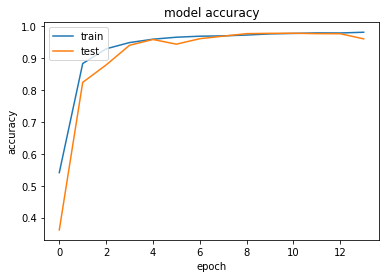

In [15]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Plot Loss Graph

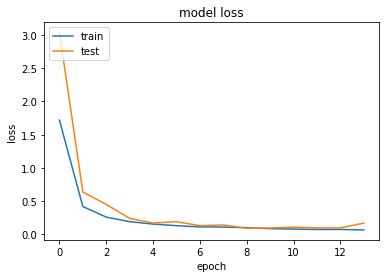

In [16]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()